# COVID 19 Data Analysis

In response to the COVID-19 pandemic, the White House and a coalition of leading research groups have prepared the COVID-19 Open Research Dataset (CORD-19). CORD-19 is a resource of over 45,000 scholarly articles, including over 33,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses. This freely available dataset is provided to the global research community to apply recent advances in natural language processing and other AI techniques to generate new insights in support of the ongoing fight against this infectious disease. There is a growing urgency for these approaches because of the rapid acceleration in new coronavirus literature, making it difficult for the medical research community to keep up.

## 0. Introduction

## 1. Overview - Data Exploration

## 2. Topic Modeling

## 3. Model Performance

## 4. Model Comparison

## 5. Conclusion

## 6. Outlook

In [2]:
!pip install wordcloud

     |████████████████████████████████| 368kB 19.6MB/s eta 0:00:01


In [3]:
import pandas as pd
import os
import json
import re
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

style.use("ggplot")

## a) Not needed in IBM Watson Studio - Just load CSV

## First extract the data and combine:

The data is mainly in json format. We will convert it into a pandas data frame and save it as csv for easyer use later on.
#### First lets get an overview over the json document:

In [ ]:
dirs = ["biorxiv_medrxiv", "noncomm_use_subset", "comm_use_subset"]

docs = []

for d in dirs:
    for file in os.listdir(f"{d}/{d}"):
        file_path = f"{d}/{d}/{file}"
        j = json.load(open(file_path, "rb"))
        
        #print(j["metadata"])
        for key, value in j.items():
            print(f"key: {key} \n value: {value}")

Title, abstract and fulltext are of the most interest for us. Whereas title is listed under "metadata", abstract and fulltext are saved as dicts under their own tags. For both of them the text part is then again listed under "text". So lets extract them:

#### Iterate over every json file in the folder and append it to one list, consisting of title, abstract and full text

In [ ]:
for d in dirs:
    for file in os.listdir(f"{d}/{d}"):
        file_path = f"{d}/{d}/{file}"
        j = json.load(open(file_path, "rb"))
            
        title = j["metadata"]["title"]
        
        try:
            abstract = j["abstract"][0]["text"]
        except:
            abstract = ""
        
        full_text = ""
        for text in j["body_text"]:
            full_text += text["text"] + "\n\n"
            
        docs.append([title, abstract, full_text, d])
        

#### Convert to pandas DataFrame

In [ ]:
df = pd.DataFrame(docs, columns = ["title", "abstract", "full_text", "article type"])
df.head()

##### Save as csv and reload. (for an easy usage on ibm watson studio)

In [ ]:
df.to_csv("CORD19.csv", index = False)

In [ ]:
df = pd.read_csv("CORD19.csv")
df.head()

## b) Load data from csv:

In [4]:
# The code was removed by Watson Studio for sharing.

,title,abstract,full_text,article type
0,The RNA pseudoknots in foot-and-mouth disease ...,word count: 194 22 Text word count: 5168 23 24...,"VP3, and VP0 (which is further processed to VP...",biorxiv_medrxiv
1,Analysis Title: Regaining perspective on SARS-...,"During the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...",biorxiv_medrxiv
2,Healthcare-resource-adjusted vulnerabilities t...,NaN,The 2019-nCoV epidemic has spread across China...,biorxiv_medrxiv
3,"Real-time, MinION-based, amplicon sequencing f...",Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by...",biorxiv_medrxiv
4,A Combined Evidence Approach to Prioritize Nip...,Nipah Virus (NiV) came into limelight recently...,Nipah is an infectious negative-sense single-s...,biorxiv_medrxiv


## 1. Overview

#### Let us first get a rough overview over the data we have:

In [4]:
df.shape

(12718, 4)

In [9]:
df.isna().sum()

title           0
abstract        0
full_text       0
article type    0
dtype: int64

In [7]:
#replace nan values
df["abstract"] = df["abstract"].replace(np.nan, "")
df["title"] = df["title"].replace(np.nan, "")

##### There doesn't seem to be any na values. Lets make sure:

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12718 entries, 0 to 12717
Data columns (total 4 columns):
title           12718 non-null object
abstract        12718 non-null object
full_text       12718 non-null object
article type    12718 non-null object
dtypes: object(4)
memory usage: 397.5+ KB


In [15]:
df.describe()

,title,abstract,full_text,article type
count,12718,12718,12718,12718
unique,11691,10787,12526,3
top,,,Coronaviruses are a group of enveloped viruses...,comm_use_subset
freq,665,1724,3,9315


##### Though we have no na objects we still have articles without a title or abstract. That is because earlyer we filled in title and abstract with a space when there where none.  It also looks like we have some duplicates. That shouldn't matter too much though. Especially since the maximal reoccurance is 3.

##### Let's take a closer look at the article type distribution:

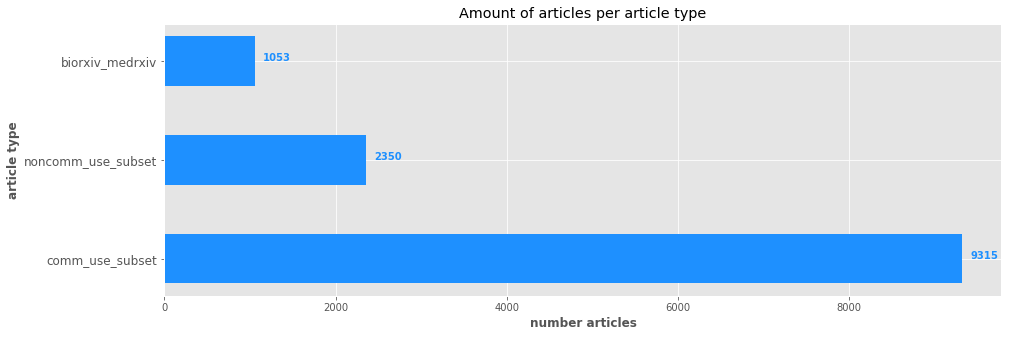

In [8]:
num_articles = df["article type"].value_counts()
y_ticks = ["comm_use_subset", "noncomm_use_subset", "biorxiv_medrxiv"]

fig, ax = plt.subplots(figsize = (15, 5))

width = 0.5      #width of each bar
ind = np.arange(len(num_articles))   # x location
ax.barh(ind, num_articles, width, color = "dodgerblue")
plt.title("Amount of articles per article type")
ax.set_yticks(ind)
ax.set_yticklabels(y_ticks, minor = False, fontsize = 12)
plt.xlabel("number articles", fontweight = "bold")
plt.ylabel("article type", fontweight = "bold")


for i,v in enumerate(num_articles):
    ax.text(v + 100, i, str(v), fontweight = "bold", color = "dodgerblue")

plt.show()

##### The data consists of three article types, most of which is the commercial use subset with 9315 articles, followed by the noncommercial use subset with a total of 2350 articles and last the biological and medical dataset with 1053 articles. In total there are 12718 articles.

### Lets look at wordcount next:

In [9]:
df_stat = df.copy()

mask = df_stat["full_text"]
mask = mask.apply(lambda x: len(x.split(" ")))

In [10]:
df_stat = df_stat.join(mask, rsuffix = "mask")
df_stat.rename(columns = {"full_textmask" : "word_count"}, inplace = True)
df_stat.head()

,title,abstract,full_text,article type,word_count
0,The RNA pseudoknots in foot-and-mouth disease ...,word count: 194 22 Text word count: 5168 23 24...,"VP3, and VP0 (which is further processed to VP...",biorxiv_medrxiv,1710
1,Analysis Title: Regaining perspective on SARS-...,"During the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...",biorxiv_medrxiv,2490
2,Healthcare-resource-adjusted vulnerabilities t...,NaN,The 2019-nCoV epidemic has spread across China...,biorxiv_medrxiv,750
3,"Real-time, MinION-based, amplicon sequencing f...",Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by...",biorxiv_medrxiv,3959
4,A Combined Evidence Approach to Prioritize Nip...,Nipah Virus (NiV) came into limelight recently...,Nipah is an infectious negative-sense single-s...,biorxiv_medrxiv,2392


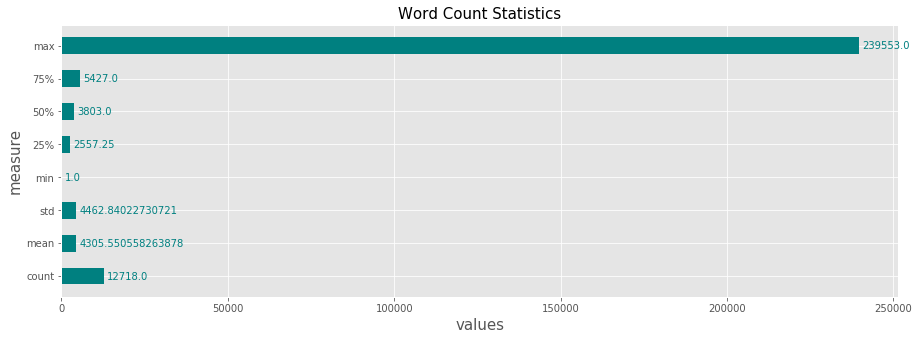

In [11]:
description = df_stat[["word_count"]].describe()

fig, ax = plt.subplots(figsize = (15, 5))

width = 0.5
ind = np.arange(len(description["word_count"]))

ax.barh(ind, description["word_count"], width, color = "teal")
plt.title("Word Count Statistics", fontsize = 15)
plt.xlabel("values", fontsize = 15)
plt.ylabel("measure", fontsize = 15)

ax.set_yticks(ind)
ax.set_yticklabels(description.index)

for i, v in enumerate(description["word_count"]):
    ax.text(v + 1000, i - 0.1, str(v), color = "teal", fontsize = 10)

plt.show()

In [12]:
description.head()

,word_count
count,12718.000000
mean,4305.550558
std,4462.840227
min,1.000000
25%,2557.250000


##### We can see that the longest article consists of up to 239,553 words wheras the shortest only has one word (it seems to be an empty row and we should check it down the line). In the mean the articles are 4305 words long with a total of 12718 articles.

### Word Occurance in Articles, Abstracts and Titles:

In [13]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/dsxuser/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [14]:
#Get stopwords from WordCloud STOPWORDS and add some more:
stopwords = list(STOPWORDS)
stopwords += "org", "doi", "https", "holder", "perprint", "copyright", "using","preprint","rights","reserved", "peer"
print(len(stopwords))

203


In [15]:
#Word Cloud for full text just for one example text for the moment, since all together is far too many data.
ex_text = df.loc[0,"full_text"]

#Strip stopwords from the text and rejoin to a single string
word_list = word_tokenize(ex_text)
result = [w for w in word_list if not w in stopwords]
result = " ".join(result)
print(result)

VP3 , VP0 ( processed VP2 VP4 virus assembly ) ( 6 ) . The P2 64 P3 regions encode non-structural proteins 2B 2C 3A , 3B ( 1-3 ) ( VPg ) , 3C pro 4 structural protein-coding region replaced reporter genes , allow study genome 68 replication without requirement high containment ( 9 , 10 ) ( figure 1A ) . The FMDV 5′ UTR largest known picornavirus UTR , comprising approximately 1300 71 nucleotides containing several highly structured regions . The first 360 nucleotides 5′ 72 end predicted fold single large stem loop termed S-fragment , followed The PKs originally predicted 1987 consist two four tandem repeats ~48 86 nucleotide region containing small stem loop downstream interaction site ( figure 1B ) 87 ( 12 ) . Due sequence similarity PKs ( figure 1C ) , speculated 88 formed duplication events viral replication , probably involving recombination . 89 Between two four PKs present different virus isolates strain 90 identified less two PKs , emphasising potential importance viral life cyc

### WordCloud for example full text:

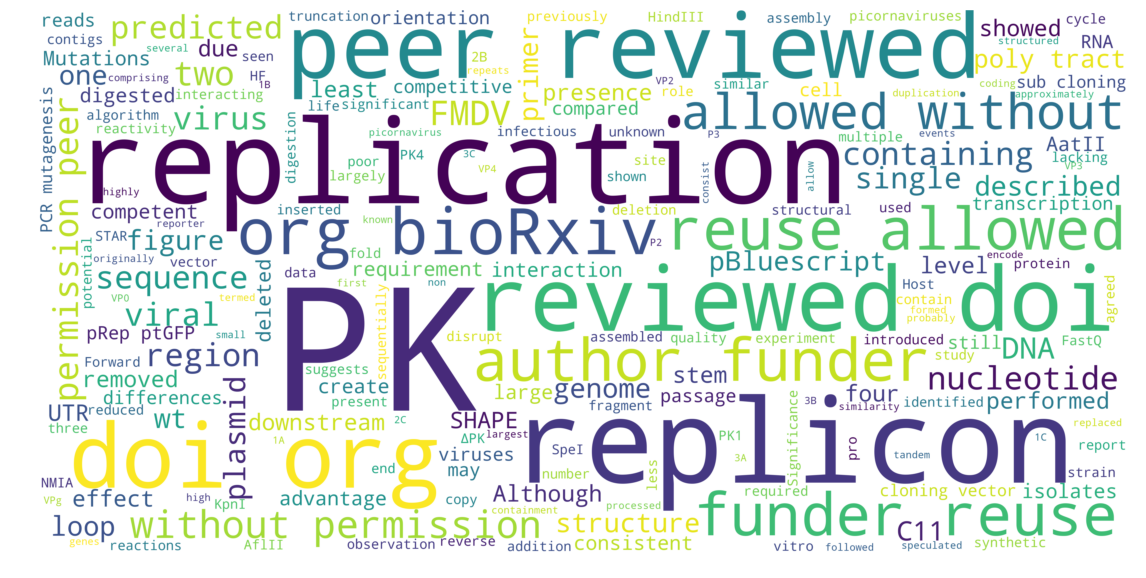

In [16]:
cloud = WordCloud(background_color = "white", width = 5000, height = 2500)
cloud.generate(result)

#Display word cloud
plt.figure(figsize = (20,10))
plt.imshow(cloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

The words found in the WordCloud don't seem to be the ones one would be expecting. This may be due to the fact that we only used one full_text as input.(not representative)

### WordCloud for all abstracts:

In [10]:
#Concatenate abstract texts to one single text
abstract_txt = " ".join(df["abstract"])

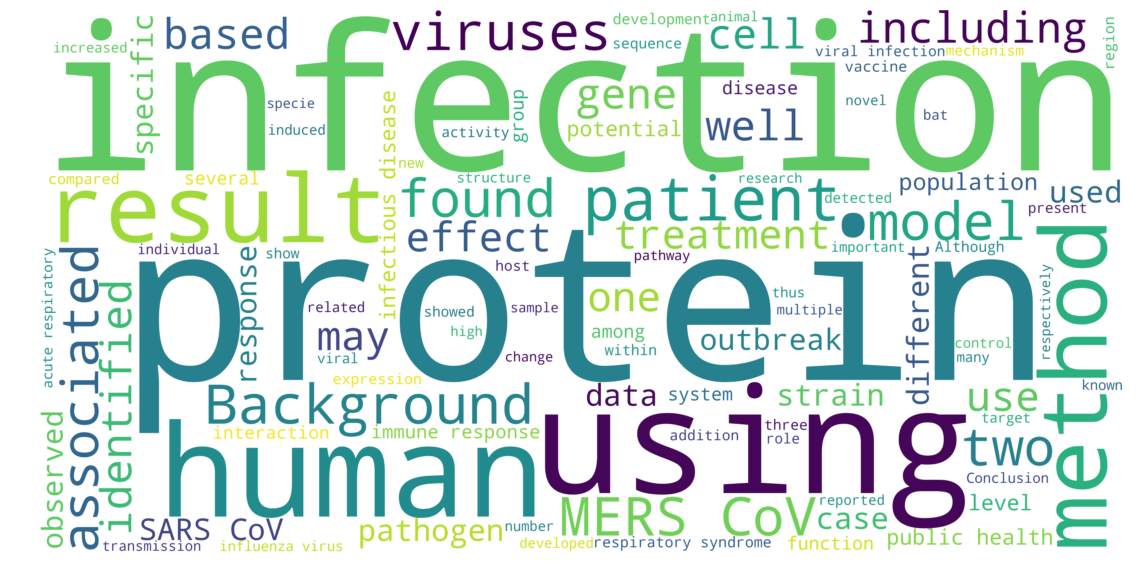

In [12]:
cloud = WordCloud(background_color = "white", width = 5000, height = 2500, max_words = 100)
cloud.generate(abstract_txt)

#Display word cloud
plt.figure(figsize = (20,10))
plt.imshow(cloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

### WordCloud for all Titles:

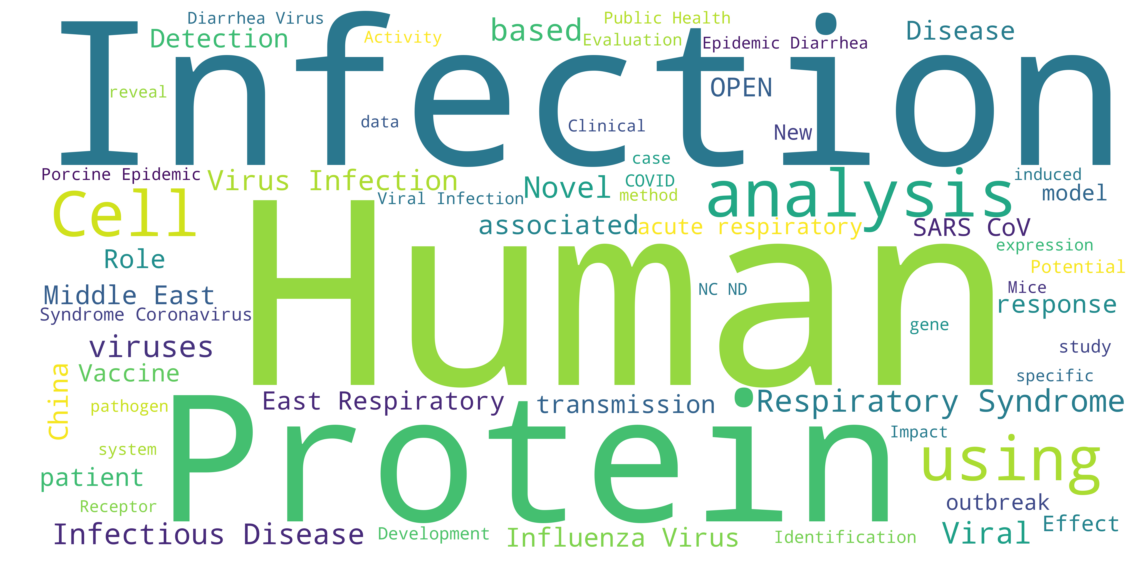

In [14]:
cloud = WordCloud(background_color = "white", width = 5000, height = 2500, max_words = 60)
title_txt = " ".join(df["title"])
cloud.generate(title_txt)

#Display Cloud:
plt.figure(figsize = (20,10))
plt.imshow(cloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

# 2. Topic Modeling:

In [5]:
!pip install gensim

     |████████████████████████████████| 24.2MB 11.5MB/s eta 0:00:01
     |████████████████████████████████| 112kB 44.0MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/51/88/6c/2bcd305b87c1e62cbcbf419e782ad9fc612cd4bbb71557502d
Successfully built smart-open


In [6]:
!pip install spacy

     |████████████████████████████████| 10.6MB 6.9MB/s eta 0:00:01
     |████████████████████████████████| 61kB 21.4MB/s eta 0:00:01
     |████████████████████████████████| 122kB 41.7MB/s eta 0:00:01
     |████████████████████████████████| 3.7MB 43.4MB/s eta 0:00:01
     |████████████████████████████████| 194kB 41.8MB/s eta 0:00:01
     |████████████████████████████████| 2.2MB 14.1MB/s eta 0:00:01
  Found existing installation: tqdm 4.31.1
    Uninstalling tqdm-4.31.1:
      Successfully uninstalled tqdm-4.31.1
  Found existing installation: importlib-metadata 0.7
    Uninstalling importlib-metadata-0.7:
      Successfully uninstalled importlib-metadata-0.7


In [7]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 6.9MB/s eta 0:00:01     |██████████████████████          | 1.1MB 6.9MB/s eta 0:00:01
     |████████████████████████████████| 296kB 26.5MB/s eta 0:00:01
     |████████████████████████████████| 552kB 45.4MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Stored in directory: /home/dsxuser/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [8]:
#To measure duration of model fitting
import time

#To pickle data without stopwords, as it takes very long to remove them.
import pickle

import nltk; nltk.download("stopwords")

from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dsxuser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
unable to import 'smart_open.gcs', disabling that module


### 2.1 Defining Stopwords

First we will define stopwords we will later strip off the input texts.  
Nltk provides a list of stopwords that we will use and expand.

In [9]:
!python -m spacy download en

     |████████████████████████████████| 12.0MB 1.6MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.tmp/pip-ephem-wheel-cache-rzgjunhg/wheels/6a/47/fb/6b5a0b8906d8e8779246c67d4658fd8a544d4a03a75520197a
Successfully built en-core-web-sm
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/opt/conda/envs/Python36/lib/python3.6/site-packages/en_core_web_sm -->
/opt/conda/envs/Python36/lib/python3.6/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [10]:
from nltk.corpus import stopwords

In [11]:
stop_words = stopwords.words("english")
print(stop_words)
print(len(stop_words))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [12]:
stop_words.extend(['from', 'subject', 're', 'edu', 'use', "org", "doi", "https", "holder", "perprint", "copyright", "using","preprint","rights","reserved", "peer"])

### 2.2 Data Selection

As the dataset is quite big with roughly 13k full texts we will focus on only the ones from type bio_med.  
Also the abstract is still in dictionary form, so we have to extract the text only.

In [13]:
# keep old df, alter new df
lda_df = df[df["article type"] == "biorxiv_medrxiv"].copy()
lda_df.head()

,title,abstract,full_text,article type
0,The RNA pseudoknots in foot-and-mouth disease ...,word count: 194 22 Text word count: 5168 23 24...,"VP3, and VP0 (which is further processed to VP...",biorxiv_medrxiv
1,Analysis Title: Regaining perspective on SARS-...,"During the past three months, a new coronaviru...","In December 2019, a novel coronavirus, SARS-Co...",biorxiv_medrxiv
2,Healthcare-resource-adjusted vulnerabilities t...,NaN,The 2019-nCoV epidemic has spread across China...,biorxiv_medrxiv
3,"Real-time, MinION-based, amplicon sequencing f...",Infectious bronchitis (IB) causes significant ...,"Infectious bronchitis (IB), which is caused by...",biorxiv_medrxiv
4,A Combined Evidence Approach to Prioritize Nip...,Nipah Virus (NiV) came into limelight recently...,Nipah is an infectious negative-sense single-s...,biorxiv_medrxiv


In [14]:
#FIXED
#Abstract is still in dict form. Convert to string:
#lda_df["abstract"] = lda_df["abstract"].apply(lambda x: x["text"] if (len(x) > 0) else x)
#lda_df.loc[0,"abstract"]

Next we have to get rid of duplicate spaces and convert the data frame to a list in order to preocess it in the next step:

### 2.3 Tokenize
Let’s tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

In [15]:
#Convert df to list
data = lda_df.values.tolist()

In [16]:
# Tokenize and remove punctuation
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

#Example output
print(data_words[0][:50])

['the', 'rna', 'pseudoknots', 'in', 'foot', 'and', 'mouth', 'disease', 'virus', 'are', 'dispensable', 'for', 'genome', 'replication', 'but', 'essential', 'for', 'the', 'production', 'of', 'infectious', 'virus', 'word', 'count', 'text', 'word', 'count', 'author', 'funder', 'all', 'rights', 'reserved', 'no', 'reuse', 'allowed', 'without', 'permission', 'abstract', 'the', 'positive', 'stranded', 'rna', 'genomes', 'of', 'picornaviruses', 'comprise', 'single', 'large', 'open', 'reading']


### 2.4 Building n-grams models:  
The next step in preprocessing is building bigram and trigram models. That means finding two, respectively three words, commonly occuring together in the text.  With the gensim phrases model we can do this. Min count and threshold define the difficulty of finding bigrams / trigrams. The higher they are set, the more difficult it is to find matching words.

In [17]:
bigram = gensim.models.Phrases(data_words, min_count = 5, threshold = 100)
trigram = gensim.models.Phrases(bigram[data_words], threshold = 100)

In [18]:
#Reduce sentence to bigrams and trigrams:
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#Print Example
print(trigram_mod[bigram_mod[data_words[0][:50]]])

['the', 'rna', 'pseudoknots', 'in', 'foot', 'and', 'mouth', 'disease', 'virus', 'are', 'dispensable', 'for', 'genome', 'replication', 'but', 'essential', 'for', 'the', 'production', 'of', 'infectious', 'virus', 'word_count', 'text', 'word_count', 'author', 'funder', 'all', 'rights_reserved_no_reuse', 'allowed_without_permission', 'abstract', 'the', 'positive_stranded', 'rna', 'genomes', 'of', 'picornaviruses', 'comprise', 'single', 'large', 'open_reading']


### 2.5 Remove stopwords, transform to bigrams and trigrams and lematize

Here we define functions for removing stopwords building n-grams with the model defined prior and lemmatizing. 

In [19]:
def remove_stop_words(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [20]:
def build_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [21]:
def build_trigrams(texts):
    return [trigram_mod[doc] for doc in texts]

In [22]:
def lemmatization(texts, allowed_postags = ["NOUN", "ADJ", "VERB", "ADV"]):
    """https://spacy.io/api/annotation"""
    texts_out = []
    
    for sentence in texts:
        doc = nlp(" ".join(sentence))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    
    return texts_out

##### Next, call the functions sequentially:

In [23]:
# remove stopwords
data_words_nostop = remove_stop_words(data_words)

# build bigrams
data_words_bigrams = build_bigrams(data_words_nostop)

# Initialize spacy en model:
nlp = spacy.load('en', disable=['parser', 'ner'])

# lemmatization, keeping only noun, adj, verb and adverb
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#Pickle the preprocessed data, as the steps up to here took quite long.
#So the next time we can skip it and just load the data.
pickle.dump(data_lemmatized, open("data_lemmatized.p", "wb"))

print(data_lemmatized[0][:50])

['virus', 'genome', 'replication', 'essential', 'production', 'infectious', 'virus', 'text', 'author', 'funder', 'abstract', 'positive', 'strand', 'genome', 'picornaviruse', 'comprise', 'single', 'large', 'frame', 'flank', 'utrs', 'virus', 'fmdv', 'unusually', 'large', 'utr', 'contain', 'structural', 'domain', 'include', 'entry', 'site', 'ire', 'facilitate', 'initiation', 'translation', 'act', 'replication', 'element', 'cre', 'less', 'well', 'characterised', 'structure', 'terminal', 'variable', 'length', 'poly', 'tract', 'approximately']


### 2.6 Define Dictionary and Corpus:

The LDA models main inputs are a dictionary and the corpus.

In [24]:
#Load pickled data:
data_lemmatized = pickle.load(open("data_lemmatized.p", "rb"))

#Dictionary - indexing each lemmatized word with an ID:
id2word = corpora.Dictionary(data_lemmatized)

#Corpus - mapping each word of a text to its ID from the dictionary:
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

#print example
print(corpus[0][:50])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 2), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 2), (22, 1), (23, 1), (24, 2), (25, 2), (26, 1), (27, 11), (28, 1), (29, 4), (30, 1), (31, 1), (32, 1), (33, 3), (34, 1), (35, 1), (36, 3), (37, 1), (38, 1), (39, 4), (40, 3), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 2), (48, 1), (49, 3)]


The tuple outputs represent the id and frequency for each word in a document.  
To retrieve the corresponding word to an id, just pass the id to the dictionary:

In [25]:
# Output word with the ID 5:
id2word[5]

'act'

### 2.7 Building the Model:

### 2.71 Laten Dirichlet Allocation - LDA:

##### Definition:  
The Dirichlet distributions are a family of continuous multivariate probability distributions. Multivariate meaning they are taking several variables into account at once (in contrast to univariate).  
The Algorithm tries to map documents to their used words and thereby finding similarities. In order to reduce the mapped connections LDA introduces a latent (hidden) layer, hence the name Laten Dirichlet Allocation.  
The hidden layer represents the topics.

##### The lda model takes the following parameters:
First we have the corpus and dictionary we discussed earlyer, as well as the number of topics.  

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.

Chunksize is the number of documents to be used in each training chunk. update_every determines how often the model parameters should be updated and passes is the total number of training passes.

In [26]:
num_topics = 20
start_time = time.time()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

lda_time = time.time() - start_time

print("--- %s seconds ---" % lda_time)

--- 68.49792695045471 seconds ---


In [27]:
# Output first 5 topics:
pprint(lda_model.print_topics()[0:5])

[(0,
  '0.030*"case" + 0.019*"license" + 0.012*"number" + 0.012*"epidemic" + '
  '0.011*"display" + 0.011*"day" + 0.010*"confirm" + 0.010*"country" + '
  '0.010*"outbreak" + 0.010*"made_available"'),
 (1,
  '0.030*"model" + 0.029*"case" + 0.021*"time" + 0.020*"number" + '
  '0.018*"estimate" + 0.014*"transmission" + 0.012*"rate" + 0.011*"individual" '
  '+ 0.010*"epidemic" + 0.010*"parameter"'),
 (2,
  '0.053*"patient" + 0.023*"license" + 0.020*"study" + 0.017*"display" + '
  '0.016*"funder" + 0.015*"case" + 0.014*"author" + 0.014*"review" + '
  '0.012*"severe" + 0.012*"clinical"'),
 (3,
  '0.014*"peptide" + 0.011*"protein" + 0.011*"figure" + 0.010*"surface" + '
  '0.009*"structure" + 0.008*"particle" + 0.008*"show" + 0.008*"image" + '
  '0.007*"review" + 0.007*"complex"'),
 (4,
  '0.041*"nurse" + 0.038*"bee" + 0.027*"colony" + 0.023*"worker" + '
  '0.019*"pollen" + 0.018*"diet" + 0.018*"feed" + 0.014*"larvae" + '
  '0.012*"consume" + 0.012*"vaginal"')]


Each topic represents the percentage of its most common words.  
The first topic for example consists to 0.088 times of the word age, 0.054 times child, etc...

#### 2.7.2 Visualization:
Lets visualize what we have found, so that we gain some value from all the work.  
For lda we can use the library pyLDAvis, which takes a very long time to load but is worth the wait, as it provides an interactive map of the found topics.  
NMF on the other hand does not come with any visualization library at the moment, so we will try to build our own visualization.

In [28]:
# Visualize the topics
pyLDAvis.enable_notebook()

In [29]:
lda_vis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

/opt/conda/envs/Python36/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [30]:
#Pickle the visualization to save time the next time.
pickle.dump(lda_vis_prepared, open("lda_vis_prepared", "wb"))

In [1]:
#Load and show the lDA visualization
lda_vis = pickle.load(open("lda_vis_prepared", "rb"))
lda_vis

NameError: name 'pickle' is not defined

In [46]:
pyLDAvis.save_html(lda_vis, "lda_vis.html")

We can use these topics to search articles of one specific topic or to filter our data. Further work might be finding the most present topic over all articles or the article fitting a specific topic the best.  But for the while we will leave it at that and proceed to measure the model accuracy.  
The found topics with LDA differ quite strongly from the ones found with NMF. At first sight I get the impression that NMF outputs more comprehendable topics. But, to be honest, I am lacking the domain knowledge for judging the topic selection reliably.

### 2.7.2 Non-negative Matrix Factorization - NMF:

##### Definition:
NMF is part of a group of multivariate analysis (like LDA) and linear Algebra (in contrast to LDA, which is probabilistic).  
It factorizes a Matrix V into two matrices W and H. All three matrices have the property of beeing non-negative.  
In its use in topic modeling the matrices represent the following:  
1. V: Document to word Matrix
2. W: The topics contained in the documents, made of of vectors
3. H: Coefficient Matrix / weights for the topics per document

NMF is, at this point in time, not provided by the gensim package. Hence we will implement it with sklearn.

##### First import sklearn libs:

In [32]:
import scipy as sp;
import sklearn;
import sys;

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer;
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;
import pickle;

In the first step we have to build a matrix with documents as columns and features (words) as rows.  
For performance reasons we will limit the features to a max of 7000.  

We can take the data_lemmatized list as our input in NMF. We just need to convert it from a list of lists into a just a list: 

In [33]:
#Our data_lemmatized list is a list of lists (for each text one sub list)
(data_lemmatized[0])

['virus',
 'genome',
 'replication',
 'essential',
 'production',
 'infectious',
 'virus',
 'text',
 'author',
 'funder',
 'abstract',
 'positive',
 'strand',
 'genome',
 'picornaviruse',
 'comprise',
 'single',
 'large',
 'frame',
 'flank',
 'utrs',
 'virus',
 'fmdv',
 'unusually',
 'large',
 'utr',
 'contain',
 'structural',
 'domain',
 'include',
 'entry',
 'site',
 'ire',
 'facilitate',
 'initiation',
 'translation',
 'act',
 'replication',
 'element',
 'cre',
 'less',
 'well',
 'characterised',
 'structure',
 'terminal',
 'variable',
 'length',
 'poly',
 'tract',
 'approximately',
 'nucleotide',
 'tandemly',
 'repeat',
 'pseudoknot',
 'investigated',
 'structure',
 'pks',
 'selective',
 'hydroxyl',
 'acetylation',
 'analyse',
 'shape',
 'analysis',
 'determine',
 'contribution',
 'replication',
 'mutation',
 'deletion',
 'experiment',
 'shape',
 'mutation',
 'experiment',
 'confirm',
 'importance',
 'previously',
 'predict',
 'pk',
 'structure',
 'function',
 'deletion',
 'experim

In [34]:
#Convert it to just one list with a simple list comprehension:
data_lemmatized_nmf = [" ".join(word) for word in data_lemmatized]

In [35]:
maxfeatures = 7000
vectorizer = CountVectorizer(analyzer = "word", max_features = maxfeatures)
#Takes only list, no array
x_counts = vectorizer.fit_transform(data_lemmatized_nmf)

In [36]:
print(type(x_counts))
#Show output for first doc:
print(x_counts[0])

<class 'scipy.sparse.csr.csr_matrix'>
  (0, 5661)	1
  (0, 720)	1
  (0, 5417)	1
  (0, 5783)	2
  (0, 2584)	1
  (0, 5145)	1
  (0, 2845)	1
  (0, 6154)	1
  (0, 5253)	1
  (0, 6774)	1
  (0, 6051)	1
  (0, 6618)	1
  (0, 1500)	1
  (0, 4614)	1
  (0, 5690)	1
  (0, 2310)	1
  (0, 6266)	1
  (0, 1419)	1
  (0, 6403)	1
  (0, 6010)	1
  (0, 5203)	1
  (0, 733)	1
  (0, 394)	1
  (0, 4787)	1
  (0, 6336)	1
  :	:
  (0, 3017)	1
  (0, 1807)	1
  (0, 6099)	3
  (0, 1245)	10
  (0, 6747)	4
  (0, 6713)	1
  (0, 6748)	1
  (0, 2409)	1
  (0, 2480)	1
  (0, 3397)	5
  (0, 5809)	7
  (0, 1131)	2
  (0, 4674)	2
  (0, 6065)	1
  (0, 4780)	1
  (0, 23)	1
  (0, 2524)	11
  (0, 458)	11
  (0, 6343)	1
  (0, 3083)	3
  (0, 4935)	1
  (0, 2122)	2
  (0, 5346)	19
  (0, 2577)	7
  (0, 6836)	13


This is the representation of our matrix. Each tuple refers to the document id and the word id. The number to the right is the wordcount.  
Next we transform the counts into a model:

In [37]:
transformer = TfidfTransformer(smooth_idf=False)
x_tfidf = transformer.fit_transform(x_counts)
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

Now build the model:

In [38]:
start_time = time.time()
# use same number of topics as for lDA
nmf_model = NMF(n_components=num_topics, init='nndsvd');

#fit the model
nmf_model.fit(xtfidf_norm)

nmf_time = time.time() - start_time

print("--- %s seconds ---" % nmf_time)

--- 1.8354408740997314 seconds ---


In [39]:
# Sklearn doesn't provide a build in function for displaying the topics, but they have example code for one on their site:
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [40]:
tfidf_feature_names = vectorizer.get_feature_names()
n_top_words = 20
print_top_words(nmf_model,tfidf_feature_names, n_top_words)

Topic #0: model epidemic number parameter rate individual time population infect infectious datum value transmission prediction intervention predict peak estimate susceptible quarantine
Topic #1: sequence gene genome read mutation strain viral contig virus variant sequencing region transcript dataset alignment sample orf nucleotide identify database
Topic #2: author review international license funder made_available display ad cc ard devil also viral brain recovery study speculate level disease growth
Topic #3: patient severe clinical covid study symptom treatment group case hospital admission test disease display mild cd day laboratory level high
Topic #4: cell expression cd fig gene mouse ace express induce infection virus tissue bcl viral ifitm level type protein lung receptor
Topic #5: nd_international alpha license made_available display funder cc author review reference end function corticosteroid antibodie infect ard speculate asymptomatic enrol figure
Topic #6: protein bind str

This output is not very good readable and since there is no visualization tool (I know of) for NMF, lets transform the output into a DataFrame.  
This makes it much easyer to read and work with.

In [41]:
nmf_dict = {}

#Transforms the found topics into a pandas DataFrame
# We can use some of the previous code (from print_top_words)
def nmf_to_df(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        #Save words / features of each topic into a list
        words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        #There are no defined topic names, so comprise on from its id.
        topic_name = "Topic #" + str(topic_idx)
        #make new list entry with topic name and its feature list.
        nmf_dict[topic_name] = words
    
    #convert dict to df
    nmf_df = pd.DataFrame(nmf_dict)
    return nmf_df

In [42]:
nmf_df = nmf_to_df(nmf_model,tfidf_feature_names, n_top_words)
nmf_df.head(20)

,Topic #0,Topic #1,Topic #2,Topic #3,Topic #4,Topic #5,Topic #6,Topic #7,Topic #8,Topic #9,Topic #10,Topic #11,Topic #12,Topic #13,Topic #14,Topic #15,Topic #16,Topic #17,Topic #18,Topic #19
0,model,sequence,author,patient,cell,nd_international,protein,piglet,case,perpetuity,detection,age,epitope,bat,organoid,vip,mxb,drug,child,city
1,epidemic,gene,review,severe,expression,alpha,bind,die,estimate,display,sample,group,vaccine,specie,liver,adaptation,ca,antiviral,pediatric,lockdown
2,number,genome,international,clinical,cd,license,structure,trial,transmission,license,primer,contact,peptide,host,human,non,mutation,ciclesonide,district,epidemic
3,parameter,read,license,covid,fig,made_available,domain,animal,day,funder,reaction,participant,cell,virus,preserve,virus,bind,virus,covid,province
4,rate,mutation,funder,study,gene,display,residue,lose,number,nthe,assay,year,protein,human,ace,sweep,interface,compound,hospitalize,people
5,individual,strain,made_available,symptom,mouse,funder,ace,fig,report,made_available,copy,individual,sequence,viral,culture,go,residue,serinc,central,number
6,time,viral,display,treatment,ace,cc,receptor,old,country,medrxiv,amplification,risk,antibody,lineage,review,protein,fig,viral,case,population
7,population,contig,ad,group,express,author,site,rear,date,author,detect,population,bind,mer,asterisk,adaptive,hexamer,inhibitor,hospital,spread
8,infect,virus,cc,case,induce,review,interaction,review,import,outcome,test,study,predict,transmission,function,enrichment,charge,protease,infection,risk
9,infectious,variant,ard,hospital,infection,reference,fig,author,confirm,ace,probe,infection,allele,phylogenetic,emergent,bootstrap,mad,activity,clinical,country


We can instantly see some words, that don't contribute much to the task of comprising the topics.  
Thus we will add them to the list of stopwords we are removing:
"also", "cd","cc", "fig","bcl", "ard"

I did not do this yet, as it shows nicely that data science is a reiterative process.

## 3. Model Performance

It is quite dificult to measure model performance for nlp. Or at least I couldn't find many good measures.  
This is due to the fact, that there are no predefined topics we could measure our output against.  
After all LDA and NMF belong to the categor of unsupervised learning.  
Below we will discuss two different measures: Perplexity and Coherence.  
Sadly there doesn't seem to be a function for either for the NMF.

In [43]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.628223140365908

Coherence Score:  0.486205579378017


### Reading the scores:

#### 1. Perplexity / predictive likelyhood:  
##### Perplexity measures how good a new dataset (article) fits into the predictions. This measurement however has been shown to not closely correlate with human judgment and might even slightly anti correlate. A better measure might therefor be coherence.

#### 2. Topic Coherence:
##### Topic Coherence measures a topic based on the semantic similarity of its most comon keywords.  Topic Coherence itself is again divided in different sub measures. The one used in this notebook is C_V:  C_V is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosine similarity

##### A coherence score of 0.50 isn't the best. To improve on this we could try different numbers of topics for the model, just as with a k nearest neighbour model.

## 4. Model Comparison

As there is no score for perplexity or coherence in NMF, all that is left to compare the two models with is:

1. The time it took to compute them.
2. Personal judgement.

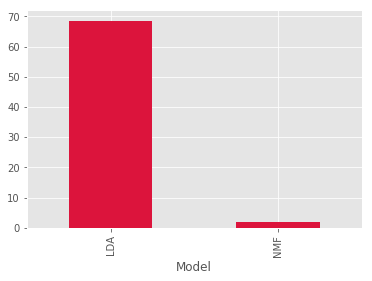

In [44]:
model_performance_dict = {"Model": ["LDA", "NMF"],"duration": [lda_time, nmf_time]}
performance_df = pd.DataFrame(model_performance_dict)
performance_df.set_index("Model", inplace = True)
performance_df["duration"].plot(kind = "bar", color = "crimson")

As we can see, NMF is by far the quicker model.

## 5. Conclusion

We saw that many ways lead to Rome, or in this case to topics.
LDA has with pyLDAvis by far the better visualization options of the two considered models.  
This provides one with far more usability in my opinion. But since NMF doesn't take long to build and the topics seem to be more comprehendable, I think it is definetly worth the few extra steps. Be it just for cross checking the LDA model.

##### Other options:
In the process of making this notebook I also looked in other modeling techniques.
One of them, lda2vec, particularily sounded interesting and promising.  
It combines the locality of word2vec with the benefits of LDA, by doing both, guessing surrounding words and building topics at the same time.  
Sadly though, the implementation provided on github (https://github.com/cemoody/lda2vec) doesn't seem to be working properly. 

##### Outlook:
Modeling possible topics from the COVID-19 dataset is just the beginning.  
Next up will be making use of the found topics, by extracting needed information and combining it to give reliable answers to questions asked by medical professionals.

# Task Nr.1: Incubation

#### In this section we will try to extract as much information, regarding incubation, as possible out of the full-texts.  Therefor we will parse every sentence and look for any expression containing a number(up to two digits) followed by the keyword "day".  This will result in some false data. We will take care of that along the way.

In [ ]:
incubation = df[df["full_text"].str.contains("incubation")]
incubation.reset_index(inplace = True)
incubation.head()

In [ ]:
texts = incubation["full_text"].values

incubation_times = []

for text in texts:
    
    for sentence in text.split(". "):
        
        if "incubation" in sentence:                        
            incubation_time = re.findall(r"\d{1,2} day", sentence)
            
            if len(incubation_time) == 1:
                
                num = incubation_time[0].split(" ")[0]
                
                #if int(num) > 24:
                    #Printing outliers showed that any result for incubation_time over 28 is due to floating numbers.
                    #We will therefor not append them to the list
                    #print(num)
                    #print(sentence)
                    #print
                    
                if int(num) < 29:
                    
                    incubation_times.append(float(num))
                    

In [ ]:
incubation_times.sort()
print(incubation_times)
print(len(incubation_times))

### Lets plot the result to see where we are at:

In [ ]:
plt.figure(figsize = (10,10))
plt.hist(incubation_times, bins = 15, color = "steelblue")
plt.ylabel("appearances")
plt.xlabel("Incubation period (days)")
plt.show()